In [888]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib.path
from scipy import ndimage
path = '/Users/inchanji/Research/faceData/MTFL/'

In [1019]:
def rotate(np_img, deg = 10):
    img = ndimage.rotate(np_img, deg, mode='wrap', reshape=False)
    return img 

def rotate_pts(pts, pos0, deg = 10):
    rad = np.pi / 180 * deg
    pts_rot = pts.copy()
    for i, pos in enumerate(pts):
        pts_rot[i,0] =  pos0[0] + np.cos(rad) * (pos[0] - pos0[0]) + np.sin(rad) * (pos[1] - pos0[1])
        pts_rot[i,1] =  pos0[1] + np.cos(rad) * (pos[1] - pos0[1]) - np.sin(rad) * (pos[0] - pos0[0])
        
    return pts_rot

In [946]:
np.cos(np.pi)

-1.0

In [1227]:

def clipfaceimg(img, pts0, resize = None, fac = None):
    pts  	= pts0.copy()
    xpos 	= pts[:,0]
    ypos 	= pts[:,1]

    left    = np.min(xpos)
    right   = np.max(xpos)

    top     = np.max(ypos)
    bottom  = np.min(ypos)

    xcen    = 0.5 * (right + left)
    ycen    = 0.5 * (top + bottom)    

    width  	= right - left
    height 	= top - bottom

    x0 		= int(np.max([0, xcen - width  * fac[0] / 2]))
    x1 		= int(np.min([np.shape(img)[1], xcen + width * fac[0] / 2 + 1]))

    y0 		= int(np.max([0, ycen - height * fac[1] / 2]))
    y1 		= int(np.min([np.shape(img)[0], ycen + height * fac[1] / 2 + 1]))

    pts 	-= [x0, y0]

    imgclip = img[y0:y1,x0:x1].copy()

    if resize is not None:
        normxfac = resize[0] / (x1 - x0)
        normyfac = resize[1] / (y1 - y0)
        imgclip  = cv2.resize(imgclip.astype('float'), (resize[0], resize[1]), cv2.INTER_AREA) 

        pts[:,0] *= normxfac 
        pts[:,1] *= normyfac

    return imgclip.astype('int'), pts




def index_face_attribute():
    IND 			= []
    ind_face 		= np.arange(27,dtype=int)
    ind_face[17:] 	= ind_face[17:][::-1]
    IND.append(ind_face)
    ind_reye 		= np.linspace(36,41, 41-36+1, dtype=int)
    IND.append(ind_reye)
    ind_leye 		= np.linspace(42,47, 47-42+1, dtype=int)
    IND.append(ind_leye)
    ind_nose 		= np.linspace(31,35, 35-31+1, dtype=int)
    ind_nose 		= np.concatenate(([27],ind_nose))
    IND.append(ind_nose)
    ind_mouse 		= np.linspace(48,59, 59-48+1, dtype=int)
    IND.append(ind_mouse)
    return IND


def maskmap(MASKCOLOR, IND, pts):
    MASKS = []
    BNDRY = []
    for n in range(len(MASKCOLOR)):
        pos_x 		= pts[IND[n],0].copy()
        pos_y 		= pts[IND[n],1].copy()
        temp_list 	= []
        for a, b in zip(pos_x, pos_y):
            temp_list.append([a, b])

        polygon  	= np.array(temp_list)
        left     	= np.min(polygon, axis=0)
        right    	= np.max(polygon, axis=0)

        x 			= np.arange(np.ceil(left[0]), np.floor(right[0])+1)
        y 			= np.arange(np.ceil(left[1]), np.floor(right[1])+1)

        xv, yv  	= np.meshgrid(x, y, indexing='xy')
        points  	= np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

        path     	= matplotlib.path.Path(polygon)
        mask     	= path.contains_points(points)
        mask.shape 	= xv.shape

        x0 = int(yv[0,0])
        x1 = int(yv[0,0] + np.shape(mask)[0])
        y0 = int(xv[0,0])
        y1 = int(xv[0,0] + np.shape(mask)[1])

        MASKS.append(mask)
        BNDRY.append([x0,x1,y0,y1])

    return MASKS, BNDRY

def segmentation_map(img, pts0):
    labels          = [ 1, 2, 3, 4, 5 ]  # [face, right eye, left eye, nose, mouse]
    label_rgbcolors = [ [0, 0, 255], [255, 0, 0], [255, 255, 0], [0, 255, 0],  [0, 255, 255] ] #  [Blue Red Yellow Green Cyan]

    index           = index_face_attribute()
    if len(label_rgbcolors) != len(index): 
        return None

    masks, bndry 	= maskmap(labels, index, pts0)
    seg 			= np.zeros(np.shape(img)[:2], dtype=int)
    maskcolor  		= np.zeros(np.shape(img), dtype=int)

    for n in range(len(masks)):
        x0, x1, y0, y1 = bndry[n]

        x0 = int(np.max([0, x0]))
        y0 = int(np.max([0, y0]))

        x1 = int(np.min([x1, np.shape(img)[0]]))
        y1 = int(np.min([y1, np.shape(img)[1]]))

        for i in range(x0,x1):
            for j in range(y0,y1):
                if masks[n][i-x0,j-y0]:
                    if (n == 1)  or (n == 2):
                        seg[i-1:i+2,j-1:j+2]         = labels[n]
                        maskcolor[i-1:i+2,j-1:j+2,:] = label_rgbcolors[n]
                    else:
                        seg[i,j]         =  labels[n]
                        maskcolor[i,j,:] = label_rgbcolors[n]

    
    return seg, maskcolor


def move_img_to_center(img, pts):
    xpts, ypts   = pts[:,0], pts[:,1]
    xpmed, ypmed = np.median(xpts), np.median(ypts)

    xshift = int(np.shape(img)[1]/2 - xpmed)
    yshift = int(np.shape(img)[0]/2 - ypmed)

    imgroll = np.roll(img, (yshift, xshift), axis = (0,1))
    
    pts_out = pts.copy()
    pts_out += [xshift, yshift]
    
    return imgroll, pts_out
        

def segmentation_map_new(img0, pts0, maxdeg = 50, resize = (96, 96), facrange = (2, 4), maxshift = 0.5):
    labels          = [ 1, 2, 3, 4, 5 ]  # [face, right eye, left eye, nose, mouse]
    label_rgbcolors = [ [0, 0, 255], [255, 0, 0], [255, 255, 0], [0, 255, 0],  [0, 255, 255] ] #  [Blue Red Yellow Green Cyan]

    deg = int(maxdeg * (np.random.uniform()*2 - 1)*np.random.uniform()) // 10 * 10
    index           = index_face_attribute()
    if len(label_rgbcolors) != len(index): 
        return None

    fac = (facrange[0] + (facrange[1]-facrange[0]) * np.random.uniform()) // 0.5 * 0.5
    fac = (fac, fac)
    img, pts   = move_img_to_center(img0, pts0)
    img        = rotate(img, deg = deg)
    pts        = rotate_pts(pts, np.array(np.shape(img)[:2][::-1])/2., 
                            deg = deg)
    
    img, pts   = clipfaceimg(img, pts, resize = resize, fac = fac)
    
    masks, bndry 	= maskmap(labels, index, pts)
    seg 			= np.zeros(np.shape(img)[:2], dtype=int)
    maskcolor  		= np.zeros(np.shape(img), dtype=int)

    for n in range(len(masks)):
        x0, x1, y0, y1 = bndry[n]

        x0 = int(np.max([0, x0]))
        y0 = int(np.max([0, y0]))

        x1 = int(np.min([x1, np.shape(img)[0]]))
        y1 = int(np.min([y1, np.shape(img)[1]]))

        for i in range(x0,x1):
            for j in range(y0,y1):
                if masks[n][i-x0,j-y0]:
                    if (n == 1)  or (n == 2):
                        seg[i-1:i+2,j-1:j+2]         = labels[n]
                        maskcolor[i-1:i+2,j-1:j+2,:] = label_rgbcolors[n]
                    else:
                        seg[i,j]         =  labels[n]
                        maskcolor[i,j,:] = label_rgbcolors[n]
    
    xmin = np.min(pts[:,0]); xmax = np.max(pts[:,0]);
    ymin = np.min(pts[:,1]); ymax = np.max(pts[:,1]);

    shift_right_max = np.shape(img)[1] - int(np.ceil(xmax) + 1)
    shift_left_max  = - int(np.floor(xmin) - 1)

    shift_up_max    = np.shape(img)[0] - int(np.ceil(ymax) + 1)
    shift_down_max  = - int(np.floor(ymin) - 1) 
    
    xshift          = int([shift_left_max, shift_right_max][int(np.random.uniform()*2)]  * maxshift) // 10 * 10
    yshift          = int([shift_up_max, shift_down_max][int(np.random.uniform()*2)]  * maxshift) // 10 * 10   

    shift = [yshift, xshift]

    img = np.roll(img, shift, axis=(0,1))    
    seg = np.roll(seg, shift, axis=(0,1))    
    maskcolor = np.roll(maskcolor, shift, axis=(0,1))        
    
    return img, pts + shift[::-1], seg, maskcolor

    

In [1139]:
def extract_pts(path):
    arr = []
    for i in open(path):
        try: 
            i = i.split('\n')[0].split(' ')
            #print(i, i[0],i[1])
            arr.append([float(i[0]), float(i[1])])
        except:
            pass
    return np.array(arr)

In [976]:
imgpath = '/Users/inchanji/Downloads/FACE_ATTRIBUTES/FULL/train/300W/outdoor_091.png'
ptspath = '/Users/inchanji/Downloads/FACE_ATTRIBUTES/FULL/train/300W/outdoor_091.pts'

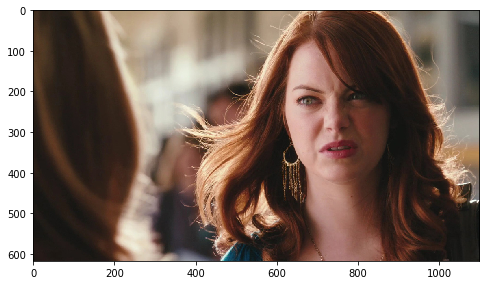

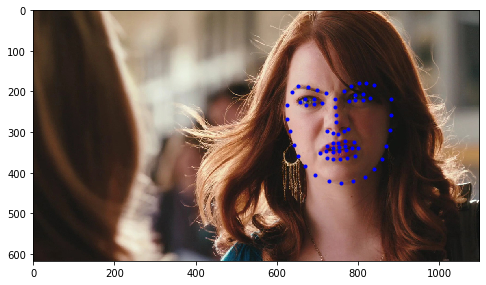

In [1030]:
img = cv2.imread(imgpath)[...,::-1]
pts = extract_pts(ptspath)

plt.figure(figsize=(8,10))
plt.imshow(img)
plt.show()


plt.figure(figsize=(8,10))
plt.imshow(img)
for pos in pts:
    plt.plot([pos[0]],[pos[1]], 'b.')
plt.show()


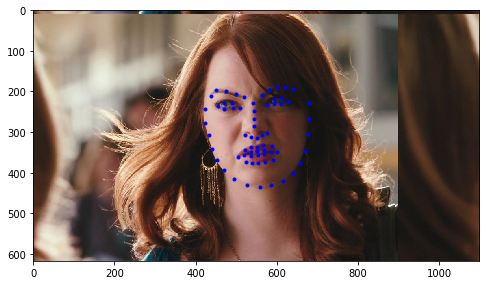

In [1021]:
img2, pts2 = move_img_to_center(img, pts)
plt.figure(figsize=(8,10))
plt.imshow(img2)
for pos in pts2:
    plt.plot([pos[0]],[pos[1]], 'b.')
plt.show()
    

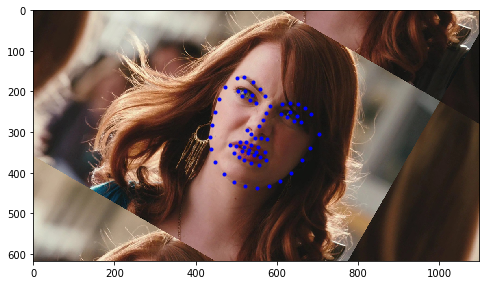

In [1024]:
deg = -30
plt.figure(figsize=(8,10))
img_rot = rotate(img2, deg = deg)
plt.imshow(img_rot)
pts2rot = rotate_pts(pts2, np.array(np.shape(img2)[:2][::-1])/2., deg = deg)
for x,y in pts2rot:
    plt.plot([x],[y], 'b.')
plt.show()


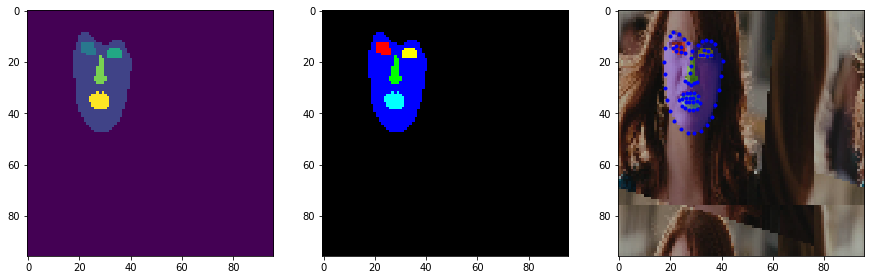

In [1239]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
img_rot, pts_rot, seg, seg_color = segmentation_map_new(img, pts, maxdeg = 40, 
                                                        resize = (96, 96), facrange = (2,5), 
                                                        maxshift = 0.5)
ax1.imshow(seg)


ax2.imshow(seg_color)
ax3.imshow(img_rot)
ax3.imshow(seg_color, alpha = 0.3)
for x,y in pts_rot:
    ax3.plot([x],[y], 'b.')

74.6863720107324 149.27917337534416 65.26345033916361 156.8456592628173


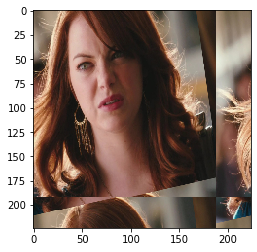

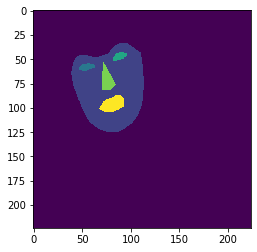

In [1130]:
fac = 0.5

xmin = np.min(pts_rot[:,0]); xmax = np.max(pts_rot[:,0]);
ymin = np.min(pts_rot[:,1]); ymax = np.max(pts_rot[:,1]);

print(xmin, xmax, ymin, ymax)

shift_right_max = np.shape(img_rot)[1] - int(np.ceil(xmax) + 1)
shift_left_max  = - int(np.floor(xmin) - 1)

shift_up_max    = np.shape(img_rot)[0] - int(np.ceil(ymax) + 1)
shift_down_max  = - int(np.floor(ymin) - 1)

xshift = int([shift_left_max, shift_right_max][int(np.random.uniform()*2)]  * fac)
yshift = int([shift_up_max, shift_down_max][int(np.random.uniform()*2)]  * fac)

#shift = [shift_down_max, shift_left_max]
#shift = [shift_up_max, shift_left_max]
shift = [yshift, xshift]

plt.imshow(np.roll(img_rot, shift, axis=(0,1)))
plt.show()

plt.imshow(np.roll(seg, shift, axis=(0,1)))
plt.show()

In [1123]:
[shift_left_max, shift_right_max][int(np.random.uniform()*2)] 

73

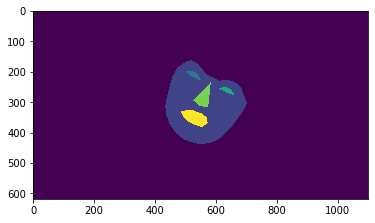

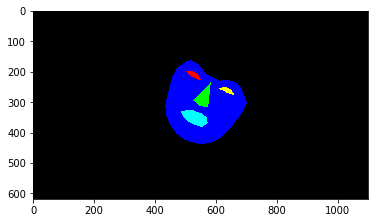

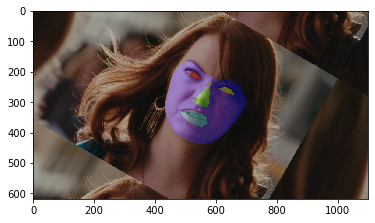

In [1026]:
seg, seg_color = segmentation_map(img_rot, pts2rot)
plt.imshow(seg)
plt.show()

plt.imshow(seg_color)
plt.show()

plt.imshow(img_rot)
plt.imshow(seg_color, alpha = 0.3)
plt.show()


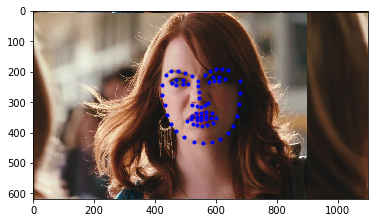

In [1023]:
xpts, ypts = pts[:,0], pts[:,1]

xpmed, ypmed = np.median(xpts), np.median(ypts)

xshift = int(np.shape(img)[1]/2 - xpmed)
yshift = int(np.shape(img)[0]/2 - ypmed)

imgroll = np.roll(img, (yshift, xshift), axis = (0,1))

plt.imshow(imgroll)

for pos in pts:
    plt.plot([pos[0]+xshift],[pos[1]+yshift], 'b.')
plt.show()



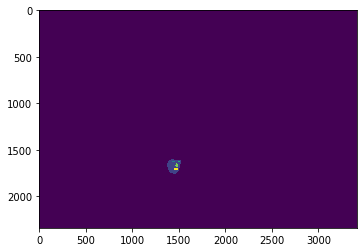

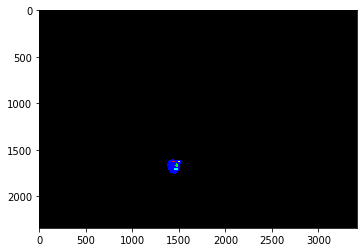

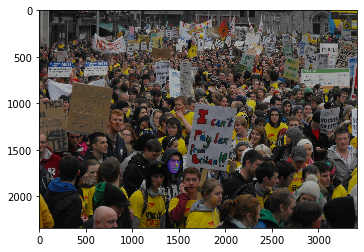

In [975]:
seg, seg_color = segmentation_map(img, pts)
plt.imshow(seg)
plt.show()

plt.imshow(seg_color)
plt.show()

plt.imshow(img)
plt.imshow(seg_color, alpha = 0.3)
plt.show()


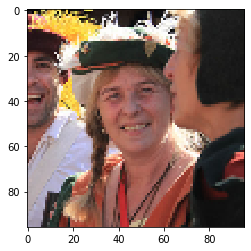

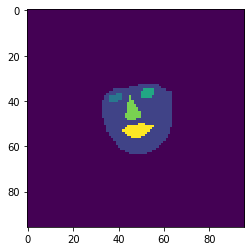

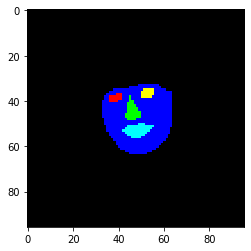

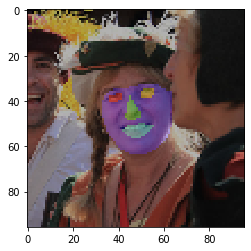

(96, 96, 3)

In [879]:

imgclip, ptsclip = clipfaceimg(img, pts, resize = (96, 96), fac = [3., 3.])
plt.imshow(imgclip)
plt.show()

segclip, segclip_color = segmentation_map(imgclip, ptsclip)

plt.imshow(segclip)
plt.show()

plt.imshow(segclip_color)
plt.show()

plt.imshow(imgclip)
plt.imshow(segclip_color, alpha = 0.3)
plt.show()

np.shape(imgclip)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


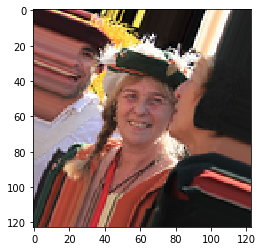

In [893]:
plt.imshow(rotate(imgclip, deg = -20))
plt.show()

In [887]:
np.min(ptsclip[:,0]), np.max(ptsclip[:,0])

(32.08044036697248, 63.906935779816514)

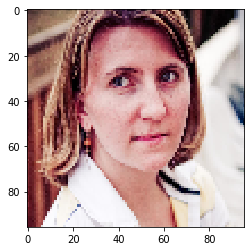

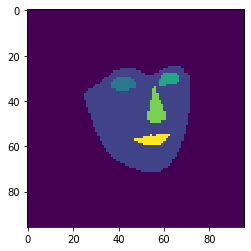

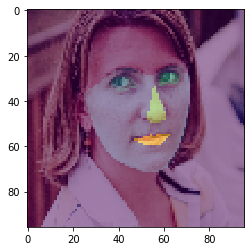

In [868]:
img = cv2.imread('/Users/inchanji/Research/faceData/faceclip/train/image/01223.png')[:,:,::-1]
seg = cv2.imread('/Users/inchanji/Research/faceData/faceclip/train/seg/01223.png')[:,:,0]
plt.imshow(img)
plt.show()
plt.imshow(seg, vmin=0, vmax =5)
plt.show()

plt.imshow(img)
plt.imshow(seg, vmin=0, vmax =5,alpha = 0.5)
plt.show()

In [815]:
np.sum((segclip - seg )**2)

ValueError: operands could not be broadcast together with shapes (224,224) (128,128) 

126.764289 249.839095
224.432619 99.376459
123.07480599999998 125.05615999999999
188.301692 161.904539
95 280
68 255


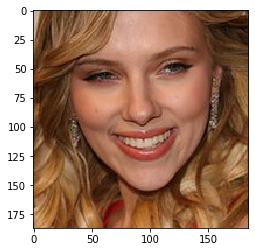

In [729]:
pos_x = pts[:,0].copy()
pos_y = pts[:,1].copy()

left     = np.min(pos_x)
right    = np.max(pos_x)

top      = np.max(pos_y)
down     = np.min(pos_y)

xcen     = 0.5*(right + left)
ycen     = 0.5*(top + down)

width  = right - left
height = top - down

print(left,right)
print(top, down)
print(width, height)
print(xcen, ycen)


xclip0 = int(np.max([0, xcen - width * 0.75]))
xclip1 = int(np.min([np.shape(img)[1], xcen + width * 0.75]))
print(xclip0, xclip1)

yclip0 = int(np.max([0, ycen - height * 0.75]))
yclip1 = int(np.min([np.shape(img)[0], ycen + height * 0.75]))
print(yclip0, yclip1)

plt.imshow(img[yclip0:yclip1,xclip0:xclip1])
plt.show()


In [730]:
MASKS = []
BNDRY = []
IND   = []
MASKCOLOR = []
MASKLABEL = []

ind_face = np.arange(27,dtype=int)
ind_face[17:] = ind_face[17:][::-1]
IND.append(ind_face)
ind_reye = np.linspace(36,41, 41-36+1, dtype=int)
IND.append(ind_reye)
ind_leye = np.linspace(42,47, 47-42+1, dtype=int)
IND.append(ind_leye)
ind_nose = np.linspace(31,35, 35-31+1, dtype=int)
ind_nose = np.concatenate(([27],ind_nose))
IND.append(ind_nose)

ind_mouse = np.linspace(48,59, 59-48+1, dtype=int)
IND.append(ind_mouse)




FACE = [0, 0, 255]  # Blue
REYE  = [255, 0, 0]   # Red
LEYE  = [255, 255, 0] # Yellow
NOSE  = [0, 255, 0]   # Green
MOUSE  = [0, 255, 255] # Cyan

MASKCOLOR.append(FACE)
MASKLABEL.append(1)
MASKCOLOR.append(REYE)
MASKLABEL.append(2)
MASKCOLOR.append(LEYE)
MASKLABEL.append(3)
MASKCOLOR.append(NOSE)
MASKLABEL.append(4)
MASKCOLOR.append(MOUSE)
MASKLABEL.append(5)





In [731]:

for n in range(len(MASKCOLOR)):
    print(n)
    pos_x = pts[IND[n],0].copy()
    pos_y = pts[IND[n],1].copy()
    

    temp_list = []
    for a, b in zip(pos_x, pos_y):
        temp_list.append([a, b])

    polygon  = np.array(temp_list)
    left     = np.min(polygon, axis=0)
    right    = np.max(polygon, axis=0)

    x        = np.arange(np.ceil(left[0]), np.floor(right[0])+1)
    y        = np.arange(np.ceil(left[1]), np.floor(right[1])+1)

    xv, yv  = np.meshgrid(x, y, indexing='xy')
    points  = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

    path     = matplotlib.path.Path(polygon)
    mask = path.contains_points(points)
    mask.shape = xv.shape


    x0 = int(yv[0,0]); x1 = int(yv[0,0]+np.shape(mask)[0])
    y0 = int(xv[0,0]); y1 = int(xv[0,0]+np.shape(mask)[1])

    MASKS.append(mask)
    BNDRY.append([x0,x1,y0,y1])


0
1
2
3
4


In [732]:
mask_img   = np.zeros(np.shape(img), dtype=int)
mask_seg   = np.zeros(np.shape(img)[:2], dtype=int)

for n in range(len(MASKS)):
    x0,x1,y0,y1 = BNDRY[n]
    print(x0,x1,y0,y1)

    for i in range(x0,x1):
        for j in range(y0,y1):
            if MASKS[n][i-x0,j-y0]:
                mask_img[i,j,:] = MASKCOLOR[n]
                mask_seg[i,j]  = MASKLABEL[n]


100 225 127 250
124 130 148 169
116 124 205 226
124 169 177 204
170 199 166 220


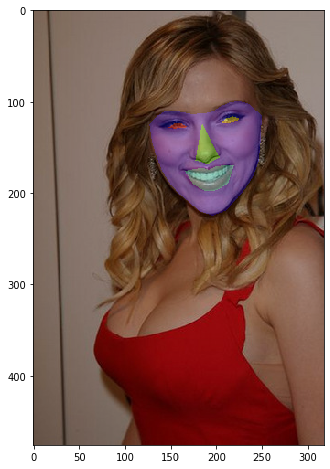

In [733]:
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.imshow(mask_img,alpha = 0.3)
plt.show()

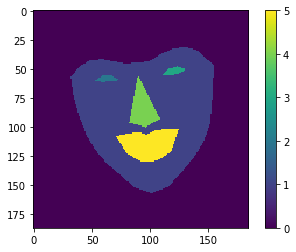

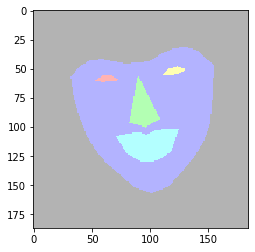

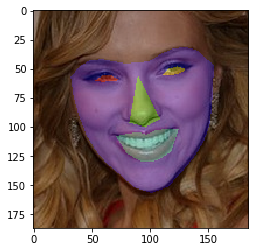

In [734]:
plt.imshow(mask_seg[yclip0:yclip1,xclip0:xclip1], vmin = 0, vmax = np.max(MASKLABEL))
plt.colorbar()
plt.show()

plt.imshow(mask_img[yclip0:yclip1,xclip0:xclip1],alpha = 0.3)
plt.show()

plt.imshow(img[yclip0:yclip1,xclip0:xclip1])
plt.imshow(mask_img[yclip0:yclip1,xclip0:xclip1],alpha = 0.3)
plt.show()



In [656]:
arr = np.array(mask_seg[yclip0:yclip1,xclip0:xclip1], dtype=float)
np.shape(arr)
arr = cv2.resize(arr, (224,224), interpolation = cv2.INTER_AREA).astype(np.int)


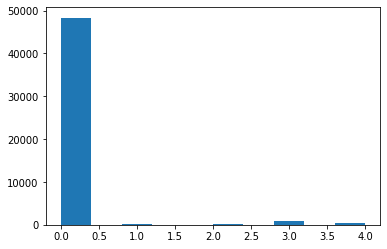

In [659]:
plt.hist(arr.ravel())
plt.show()

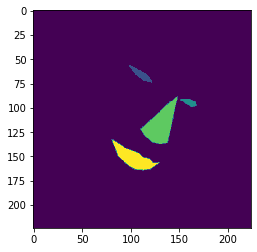

In [658]:
plt.imshow(arr)
plt.show()


In [499]:
x_pixel_reye = pts[36:42,0].copy()
y_pixel_reye = pts[36:42,1].copy()

#x_pixel_face[5:] = x_pixel_face[5:][::-1]
#y_pixel_face[5:] = y_pixel_face[5:][::-1]

temp_list = []
for a, b in zip(x_pixel_reye, y_pixel_reye):
    temp_list.append([a, b])

polygon  = np.array(temp_list)
left     = np.min(polygon, axis=0)
right    = np.max(polygon, axis=0)

x        = np.arange(np.ceil(left[0]), np.floor(right[0])+1)
y        = np.arange(np.ceil(left[1]), np.floor(right[1])+1)

xv, yv  = np.meshgrid(x, y, indexing='xy')
points  = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

path     = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = xv.shape


x0 = int(yv[0,0]); x1 = int(yv[0,0]+np.shape(mask)[0])
y0 = int(xv[0,0]); y1 = int(xv[0,0]+np.shape(mask)[1])

MASKS.append(mask)
BNDRY.append([x0,x1,y0,y1])


x_pixel_leye = pts[42:48,0].copy()
y_pixel_leye = pts[42:48,1].copy()

#x_pixel_face[5:] = x_pixel_face[5:][::-1]
#y_pixel_face[5:] = y_pixel_face[5:][::-1]

temp_list = []
for a, b in zip(x_pixel_leye, y_pixel_leye):
    temp_list.append([a, b])

polygon  = np.array(temp_list)
left     = np.min(polygon, axis=0)
right    = np.max(polygon, axis=0)

x        = np.arange(np.ceil(left[0]), np.floor(right[0])+1)
y        = np.arange(np.ceil(left[1]), np.floor(right[1])+1)

xv, yv  = np.meshgrid(x, y, indexing='xy')
points  = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

path     = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = xv.shape


x0 = int(yv[0,0]); x1 = int(yv[0,0]+np.shape(mask)[0])
y0 = int(xv[0,0]); y1 = int(xv[0,0]+np.shape(mask)[1])

MASKS.append(mask)
BNDRY.append([x0,x1,y0,y1])




In [500]:
MASKCOLOR = []

FACE = [255, 0, 0]
EYE  = [0, 255, 0]

MASKCOLOR.append(FACE)
MASKCOLOR.append(EYE)
MASKCOLOR.append(EYE)

mask_img   = np.zeros(np.shape(img), dtype=int)

for n in range(len(MASKS)):
    x0,x1,y0,y1 = BNDRY[n]
    print(x0,x1,y0,y1)


    for i in range(x0,x1):
        for j in range(y0,y1):
            if MASKS[n][i-x0,j-y0]:
                mask_img[i,j,:] = MASKCOLOR[n]


345 700 189 533
383 405 259 323
383 401 395 466
395 525 321 382


IndexError: list index out of range

In [340]:


x_pixel_face = pts[:27,0].copy()
y_pixel_face = pts[:27,1].copy()

x_pixel_face[17:] = x_pixel_face[17:][::-1]
y_pixel_face[17:] = y_pixel_face[17:][::-1]

temp_list = []
for a, b in zip(x_pixel_face, y_pixel_face):
    temp_list.append([a, b])

polygon  = np.array(temp_list)
left     = np.min(polygon, axis=0)
right    = np.max(polygon, axis=0)

x        = np.arange(np.ceil(left[0]), np.floor(right[0])+1)
y        = np.arange(np.ceil(left[1]), np.floor(right[1])+1)

xv, yv  = np.meshgrid(x, y, indexing='xy')
points  = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

path     = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = xv.shape

x0 = int(yv[0,0]); x1 = int(yv[0,0]+np.shape(mask)[0])
y0 = int(xv[0,0]); y1 = int(xv[0,0]+np.shape(mask)[1])

MASKS.append(mask)
BNDRY.append([x0,x1,y0,y1])

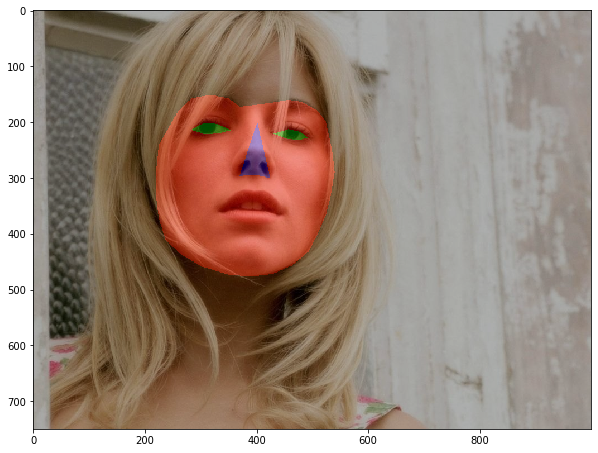

In [347]:
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.imshow(mask_img,alpha = 0.3)
plt.show()

In [278]:
np.max(mask_img)

255

In [312]:

x_pixel_reye = pts[31:36,0].copy()
y_pixel_reye = pts[31:36,1].copy()

x_pixel_reye = np.concatenate([[pts[27,0]],x_pixel_reye])
y_pixel_reye = np.concatenate([[pts[27,1]],y_pixel_reye])

#x_pixel_face[5:] = x_pixel_face[5:][::-1]
#y_pixel_face[5:] = y_pixel_face[5:][::-1]

temp_list = []
for a, b in zip(x_pixel_reye, y_pixel_reye):
    temp_list.append([a, b])

polygon  = np.array(temp_list)
left     = np.min(polygon, axis=0)
right    = np.max(polygon, axis=0)

x        = np.arange(np.ceil(left[0]), np.floor(right[0])+1)
y        = np.arange(np.ceil(left[1]), np.floor(right[1])+1)

xv, yv  = np.meshgrid(x, y, indexing='xy')
points  = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

path     = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = xv.shape



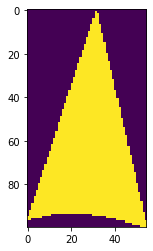

In [313]:
plt.imshow(mask)
plt.show()

In [308]:
np.concatenate(([0],x_pixel_reye))

array([  0.   , 401.099, 369.382, 384.185, 396.365, 409.388, 424.806])

In [310]:
pts

array([[224.927, 241.47 ],
       [220.653, 283.261],
       [219.   , 325.6  ],
       [224.663, 371.13 ],
       [236.867, 410.95 ],
       [265.634, 437.664],
       [302.981, 459.148],
       [349.893, 473.248],
       [390.999, 476.709],
       [430.023, 471.76 ],
       [463.906, 456.668],
       [493.606, 431.77 ],
       [509.386, 401.683],
       [524.851, 365.238],
       [533.701, 329.189],
       [540.205, 288.942],
       [535.262, 248.634],
       [259.308, 180.734],
       [283.652, 157.568],
       [317.603, 151.   ],
       [349.871, 157.833],
       [370.917, 172.764],
       [427.6  , 165.49 ],
       [457.142, 160.431],
       [481.072, 163.821],
       [508.133, 178.798],
       [524.184, 198.856],
       [401.378, 200.127],
       [401.172, 217.146],
       [401.131, 234.062],
       [401.099, 252.318],
       [369.382, 297.405],
       [384.185, 294.305],
       [396.365, 294.587],
       [409.388, 296.598],
       [424.806, 300.915],
       [283.019, 213.659],
 